<center><h1>Detecting Malaria cells using Convolutional Neural Network</h1></center>


In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
print(os.listdir("../input/cell_images/cell_images"))

['Uninfected', 'Parasitized']


In [2]:
infected = os.listdir('../input/cell_images/cell_images/Parasitized/') 
uninfected = os.listdir('../input/cell_images/cell_images/Uninfected/')

In [3]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread("../input/cell_images/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        
        image = cv2.imread("../input/cell_images/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')

In [4]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [5]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (96453, 50, 50, 3) | labels : (96453,)


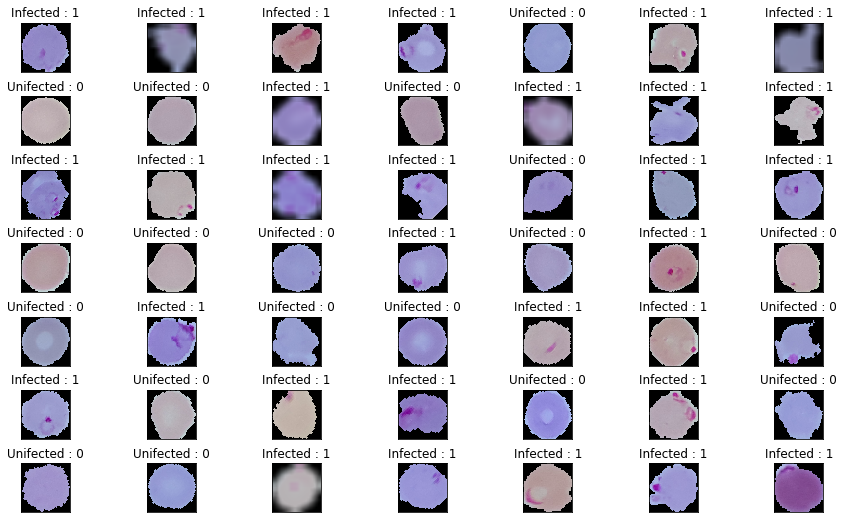

In [6]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

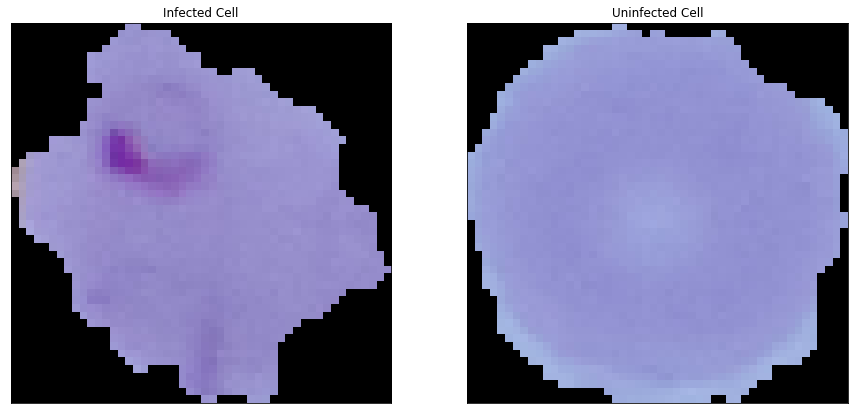

In [7]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[60000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [8]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [9]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [10]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

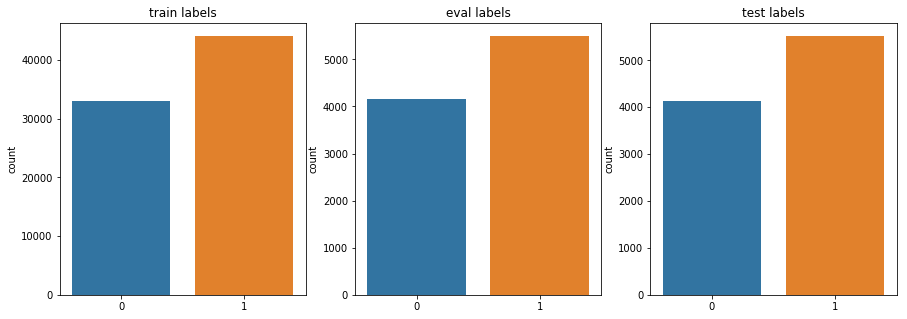

In [11]:
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([train_y , eval_y , test_y] , ['train labels','eval labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [12]:
print('train data shape {} ,eval data shape {} , test data shape {}'.format(train_x.shape,
                                                                           eval_x.shape ,
                                                                           test_x.shape))

train data shape (77162, 50, 50, 3) ,eval data shape (9645, 50, 50, 3) , test data shape (9646, 50, 50, 3)


In [13]:
tf.reset_default_graph()
def cnn_model_fn(features , labels , mode):
    input_layers = tf.reshape(features['x'] , [-1 , 50 , 50 ,3])    
    conv1 = tf.layers.conv2d(
        inputs = input_layers , 
        filters = 50 , 
        kernel_size = [7 , 7],
        padding = 'same',
        activation = tf.nn.relu
        ) 
    
    
    conv2 = tf.layers.conv2d(
        inputs = conv1, 
        filters = 90,
        kernel_size = [3 , 3],
        padding = 'valid',
        activation = tf.nn.relu
        )

        
    conv3 = tf.layers.conv2d(
        inputs = conv2 ,
        filters = 10,
        kernel_size = [5 , 5],
        padding = 'same', 
        activation = tf.nn.relu
        )
    
    pool1 = tf.layers.max_pooling2d(inputs = conv3 , pool_size = [2 , 2] ,
                                    strides = 2 )
    conv4 = tf.layers.conv2d(
        inputs = pool1 ,
        filters = 5,
        kernel_size = [3 , 3],
        padding = 'same', 
        activation = tf.nn.relu
        )

    pool2 = tf.layers.max_pooling2d(inputs = conv4 , pool_size = [2 , 2] ,
                                    strides = 2 , padding = 'same')
    
    pool2_flatten = tf.layers.flatten(pool2)
    fc1 = tf.layers.dense(
        inputs = pool2_flatten,
        units = 2000,
        activation = tf.nn.relu
        )
    fc2 = tf.layers.dense(
        inputs = fc1,
        units = 1000,
        activation = tf.nn.relu
        )
    fc3 = tf.layers.dense(
        inputs = fc2 , 
        units = 500 ,
        activation = tf.nn.relu
        )
    logits = tf.layers.dense(
        inputs = fc3 ,
        units = 2
        )
    
    predictions = {
        'classes': tf.argmax(input = logits , axis = 1),
        'probabilities': tf.nn.softmax(logits , name = 'softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode , 
                                          predictions = predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels , 
                                                 logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(loss = loss , 
                                      global_step = tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode = mode , 
                                            loss = loss , 
                                            train_op = train_op 
                                           )
    eval_metric_op = {'accuracy' : tf.metrics.accuracy(labels = labels ,
                                         predictions =  predictions['classes'])}
    
    return tf.estimator.EstimatorSpec(mode = mode , 
                                      loss = loss , 
                                      eval_metric_ops = eval_metric_op)    

In [14]:
malaria_detector = tf.estimator.Estimator(model_fn = cnn_model_fn , 
                                         model_dir = '/tmp/modelchkpt')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/modelchkpt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7a1755aacf98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [15]:
tensors_to_log = {'probabilities':'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(
    tensors = tensors_to_log , every_n_iter = 50 
    )

In [16]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_x},
    y = train_y,
    batch_size = 100 , 
    num_epochs = None , 
    shuffle = True
    )
malaria_detector.train(input_fn = train_input_fn , steps = 1 , hooks = [logging_hook])

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/modelchkpt/model.ckpt.
INFO:tensorflow:probabilities = [[0.49508548 0.5049145 ]
 [0.49956846 0.50043154]
 [0.5019671  0.49803293]
 [0.49941915 0.5005808 ]
 [0.5005073  0.4994927 ]
 [0.50211537 0.49788466]
 [0.4984826  0.5015174 ]
 [0.50072086 0.49927914]
 [0.50327843 0.49672157]
 [0.49631295 0.503687  ]
 [0.49850798 0.501492  ]
 [0.50035465 0.49964532]
 [0.49273902 0.507261  ]
 [0.50042665 0.49957335]
 [0.49767902 0.50232095]
 [0.50206405 0.4979359 ]
 [0.4990

In [17]:
malaria_detector.train(input_fn = train_input_fn , steps = 10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/modelchkpt/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/modelchkpt/model.ckpt.
INFO:tensorflow:loss = 0.69171864, step = 1
INFO:tensorflow:global_step/sec: 38.7059
INFO:tensorflow:loss = 0.689324, step = 101 (2.585 sec)
INFO:tensorflow:global_step/sec: 39.8751
INFO:tensorflow:loss = 0.68867934, step = 201 (2.508 sec)
INFO:tensorflow:global_step/sec: 39.9351
INFO:tensorflow:loss = 0.6879895, step = 301 (2.504 sec)
INFO:tensorflow:global_step/sec: 39.6612
INFO:tensorflow:loss = 0.6901924, step = 401 (2.521 sec)
INFO:tensorflow:global_step/sec: 40.0104
INFO:tensorflow:loss = 0.6876701, step = 501 (2.500 sec)
INFO:tensorflow:global_step/sec: 39.8169
INFO:tensorflow:loss = 0.68048894, step = 6

In [26]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': eval_x},
    y = eval_y , 
    num_epochs = 1 , 
    shuffle = False
    )
eval_results = malaria_detector.evaluate(input_fn = eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2024-12-04-03:07:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/modelchkpt/model.ckpt-10001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2024-12-04-03:07:33
INFO:tensorflow:Saving dict for global step 10001: accuracy = 0.8856402, global_step = 10001, loss = 0.30656418
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10001: /tmp/modelchkpt/model.ckpt-10001
{'accuracy': 0.8856402, 'loss': 0.30656418, 'global_step': 10001}


In [19]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x' : test_x},
    y = test_y,
    num_epochs = 1,
    shuffle = False
    )

y_pred = malaria_detector.predict(input_fn = pred_input_fn)
classes = [p['classes'] for p in y_pred]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/modelchkpt/model.ckpt-10001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [20]:
classes

[0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,


In [21]:
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
print('{} \n{} \n{}'.format(confusion_matrix(test_y , classes) , 
                           classification_report(test_y , classes) , 
                           accuracy_score(test_y , classes)))

[[3453  672]
 [ 368 5153]] 
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4125
           1       0.88      0.93      0.91      5521

   micro avg       0.89      0.89      0.89      9646
   macro avg       0.89      0.89      0.89      9646
weighted avg       0.89      0.89      0.89      9646
 
0.8921832884097035


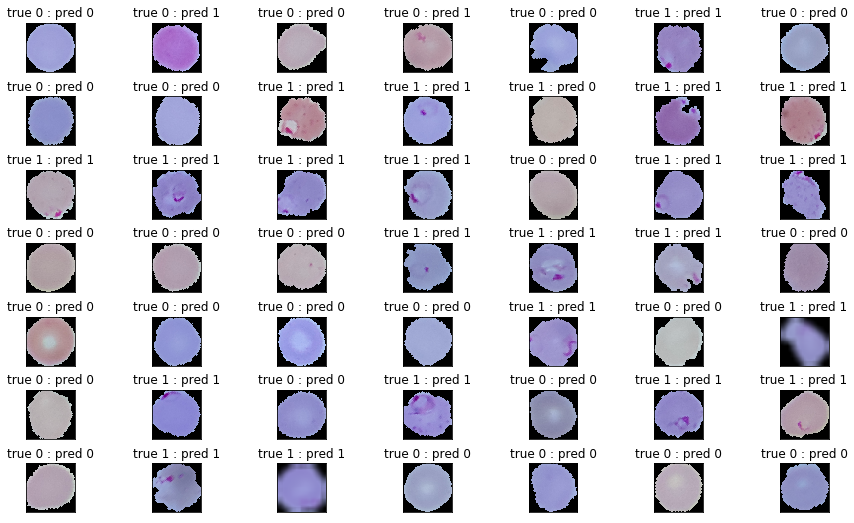

In [22]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y[r[0]] , classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [23]:
classes

[0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,


In [24]:
x=5

In [25]:
def serving_input_receiver_fn():
    feature_spec = {
        'x': tf.placeholder(dtype=tf.float32, shape=[None, 50, 50, 3])  # Input shape
    }
    return tf.estimator.export.ServingInputReceiver(features=feature_spec, receiver_tensors=feature_spec)

# Export the model
export_dir = malaria_detector.export_savedmodel(
    export_dir_base="/kaggle/working/malaria_model",
    serving_input_receiver_fn=serving_input_receiver_fn
)

print(f"Model exported to: {export_dir}")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tmp/modelchkpt/model.ckpt-10001
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /kaggle/working/malaria_model/temp-b'1733281652'/saved_model.pb
Model exported to: b'/kaggle/working/malaria_model/1733281652'


In [27]:
# save the mode

In [28]:
malaria_detector.save("/kaggle/working/model.keras")

AttributeError: 'Estimator' object has no attribute 'save'

In [30]:
import shutil
shutil.make_archive("kaggle_output_final", 'zip', "/kaggle/working/malaria_model")

'/kaggle/working/kaggle_output_final.zip'